In [1]:
#!/usr/bin/env python
# coding: utf-8


import numpy as np
import time as T
from joblib import Parallel, delayed
from scipy.interpolate import griddata,interpn,RegularGridInterpolator
import math
import os
import datetime
import cv2
from ftplib import FTP
import rioxarray
import xarray as xr
import paramiko
from scp import SCPClient
import subprocess
import datetime as dt

target ='/data01/people/liwei/AC_test/'

SZA_PATH = '/data01/GEO/INPUT/ANGLE/Solar_Zenith_Angle_u2/'
SAA_PATH = '/data01/GEO/INPUT/ANGLE/Solar_Azimuth_Angle_u2/'
VZA_PATH = '/data01/GEO/INPUT/ANGLE/Viewer_Zenith_Angle/AHI_VZA_10.dat'
VAA_PATH = '/data01/GEO/INPUT/ANGLE/Viewer_Azimuth_Angle/AHI_VAA_10.dat'

LUT_PATH = '/data01/GEO/INPUT/LUT/'
CAMS_PATH = '/data01/GEO/INPUT/ATMOSPHERE/'
DN_PATH = '/data01/GEO/INPUT/'
CAMS_AERO_PATH = '/data01/GEO/INPUT/AEROSOL_TYPE/'
AL_PATH = '/data01/GEO/INPUT/ELEVATION_GEO/AHI/MERIT_DEM_AHI_10km.dat'

res = 0.01
u_lat,d_lat = 60,-60
l_lon,r_lon = 85,205

row_AHI = 12000
col_AHI = 12000

AHI_lat = np.linspace(60 - res/2 ,-60 + res/2,row_AHI)
AHI_lon = np.linspace(85 + res/2 ,205 - res/2,col_AHI)


/data01/people/liwei/anaconda3/envs/python36/lib/python3.6/site-packages/paramiko/transport.py:33: CryptographyDeprecationWarning: Python 3.6 is no longer supported by the Python core team. Therefore, support for it is deprecated in cryptography and will be removed in a future release.
  from cryptography.hazmat.backends import default_backend


In [2]:

   
class H8_data:

    def __init__(self , account , pw , band , band_number , date):
        self.account = account
        self.pw = pw
        self.band = band
        self.band_number = band_number
        self.date = date
    
    def get_path(self):
        return '/data01/GEO/ORGDATA/H8AHI/hmwr829gr.cr.chiba-u.ac.jp/gridded/FD/V20151105/' + self.date[0:6] + '/' + self.band.upper() + '/'

    def get_filename(self):
        return self.date + "." + self.band + "." + self.band_number + ".fld.geoss.bz2"
    
    def DN2TBB(self,data):
        LUT=np.loadtxt(DN_PATH + 'count2tbb_v102/' + self.band + "." + self.band_number)
        return LUT[data,1]
    
    def file_path(self):
        return self.get_path() + self.get_filename() 
                 
    def download_H8data(self):
        client = paramiko.SSHClient()
        client.load_system_host_keys()
        client.set_missing_host_key_policy(paramiko.AutoAddPolicy())
        client.connect(hostname='10.4.123.47', port=22, username=self.account, password=self.pw)
        scp = SCPClient(client.get_transport())
        sftp = client.open_sftp()

        try :
            sftp.stat(self.file_path())

        except FileNotFoundError:
            print("File Not Found")
            return 'No data'

        else:
            scp.get(self.file_path(), folder_original+'/')
            p = subprocess.Popen('lbzip2 -d {}{}'.format(folder_original+'/',self.file_path()[-33:]),shell=True)
            p.communicate()
            print ('Himawari8/AHI data Processed Finish')
            return folder_original + '/' + self.get_filename()[:-4]
            
    def read_H8data(self):
        H8_file_path = self.download_H8data()
        if self.band == "vis":
            sr = 12000
        elif self.band == "ext":
            sr = 24000
        else:
            sr = 6000
        if H8_file_path != 'No data':
            with open(H8_file_path,'rb') as fp:
                data = np.frombuffer(fp.read(),dtype='>u2').reshape(sr,sr)
                data = self.DN2TBB(data)
                data = data/100

            print("data reading finish")
            return data
        else:
            return 'No data'
        

In [75]:

   
# class H8_data:

#     def __init__(self ,band , band_number , date):
#         self.band = band
#         self.band_number = band_number
#         self.date = date
    
#     def get_path(self):
#         return '/data01/GEO/ORGDATA/H8AHI/hmwr829gr.cr.chiba-u.ac.jp/gridded/FD/V20151105' + self.date[0:6] + '/' + self.band.upper() + '/'

#     def get_filename(self):
#         return self.date + "." + self.band + "." + self.band_number + ".fld.geoss.bz2"
    
#     def DN2TBB(self,data):
#         LUT=np.loadtxt(DN_PATH + 'count2tbb_v102/' + self.band + "." + self.band_number)
#         return LUT[data,1]
    
#     def file_path(self):
#         return self.get_path() + self.get_filename() 
                 
#     def download_H8data(self):
        
#         p = subprocess.Popen('lbzip2 -d -k {} '.format(file_path),shell=True)
#         p.communicate()
#         print ('Himawari8/AHI data Processed Finish')
#         return self.file_path()[:-4]

#     def read_H8data(self):
#         H8_file_path = self.download_H8data()
#         if self.band == "vis":
#             sr = 12000
#         elif self.band == "ext":
#             sr = 24000
#         else:
#             sr = 6000
#         if H8_file_path != 'No data':
#             with open(H8_file_path,'rb') as fp:
#                 data = np.frombuffer(fp.read(),dtype='>u2').reshape(sr,sr)
#                 data = self.DN2TBB(data)
#                 data = data/100

#             print("data reading finish")
#             return data
#         else:
#             return 'No data'
        

In [3]:
# class JAXA_data:
#     def __init__(self,account,YYYY,MM,DD,HH):
#         self.account = account
#         self.YYYY = YYYY
#         self.MM = MM
#         self.DD = DD
#         self.HH = HH
        
#     def download_JAXA(self):
#         ftp_addr = 'ftp.ptree.jaxa.jp'
#         f=FTP(ftp_addr)
#         f.login(self.account,'SP+wari8')
#         remote_filepath = '/pub/model/ARP/MS/bet/' + self.YYYY + self.MM + '/' + self.DD + '/'
#         f.cwd(remote_filepath)
#         list=f.nlst()
#         bufsize=1024
#         for name in list:
#             if name[13:17]== self.HH + '00':
#                 data=open(folder_original + name ,'wb')
#                 filename='RETR '+ name
#                 f.retrbinary(filename,data.write,bufsize)
#                 f.quit()
#                 return folder_original + name
    
    
#     def read_JAXA(self):
#         AOT_path = self.download_JAXA()
#         ds = xr.open_dataset(AOT_path)
#         aot550=ds['od550aer']
#         AOT550=aot550.interp(lon=lon_y,lat=lat_x,method="nearest")
#         AOT550=AOT550.values
#         AOT550[AOT550>=max(AOT)] = max(AOT)-(1/10000)
#         AOT550[AOT550<=min(AOT)] = min(AOT)+(1/10000)
    
        
#         bc = ds['od550bc'].interp(lon=lon_y,lat=lat_x,method="nearest")
#         so4 = ds['od550so4'].interp(lon=lon_y,lat=lat_x,method="nearest")
#         oa = ds['od550oa'].interp(lon=lon_y,lat=lat_x,method="nearest")
#         dust = ds['od550dust'].interp(lon=lon_y,lat=lat_x,method="nearest")
#         ss = ds['od550ss'].interp(lon=lon_y,lat=lat_x,method="nearest")
        
        
#         DL_6S = np.array(dust).reshape(row_AHI,col_AHI)
#         SL_6S = np.array(so4).reshape(row_AHI,col_AHI) + np.array(bc).reshape(row_AHI,col_AHI)
#         OC_6S = np.array(ss).reshape(row_AHI,col_AHI)
#         WS_6S = np.array(oa).reshape(row_AHI,col_AHI)

#         Total = DL_6S + SL_6S + OC_6S + WS_6S

#         precent_DL_6S = DL_6S / Total
#         precent_SL_6S = SL_6S / Total
#         precent_OC_6S = OC_6S / Total
#         precent_WS_6S = WS_6S / Total
#         P = np.dstack((precent_DL_6S,precent_WS_6S,precent_OC_6S,precent_SL_6S))
        
#         Aerosol_type = np.full((row_AHI,col_AHI),np.nan)
        
#         for i in range(row_AHI):
#             for j in range(col_AHI):
#                 if max(P[i,j,:]) == precent_OC_6S[i,j]:
#                     Aerosol_type[i,j] = 1
#                 else:
#                     Aerosol_type[i,j] = 0
                    
#         return np.array(AOT550).reshape(row_AHI,col_AHI),Aerosol_type

In [3]:
class LUT_interpolation:
    def __init__(self,LUT_PATH):
        self.LUT_path = LUT_PATH
    
    def LUT_interpolation(self):
        X1 = np.loadtxt(self.LUT_path + "01_band4.csv",delimiter=",").reshape(2,8,12,5,17,17,19)
        X2 = np.loadtxt(self.LUT_path + "02_band4.csv",delimiter=",").reshape(2,8,12,5,17,17,19)
        X3 = np.loadtxt(self.LUT_path + "03_band4.csv",delimiter=",").reshape(2,8,12,5,17,17,19)
        # return X1, X2, X3
        
        fn1 = RegularGridInterpolator((aero_type,water,AOT,al,sza,vza,raa),X1,bounds_error=False,fill_value=np.nan)
        fn2 = RegularGridInterpolator((aero_type,water,AOT,al,sza,vza,raa),X2,bounds_error=False,fill_value=np.nan)
        fn3 = RegularGridInterpolator((aero_type,water,AOT,al,sza,vza,raa),X3,bounds_error=False,fill_value=np.nan)
        return fn1,fn2,fn3

In [4]:
class AHI_angle:
    def __init__(self,date):
        self.date = date        
    def read_angle_data(self):
        
        AHI_date = self.date[4:11]
        
        sza_file_name = 'AHI_SZA_2020{}5.dat'.format(AHI_date)
        saa_file_name = 'AHI_SAA_2020{}5.dat'.format(AHI_date)
        
        with open(SZA_PATH + sza_file_name,'rb') as fp:
            AHI_SZA = np.frombuffer(fp.read(),dtype='u2').reshape(3000,3000) / 100
            AHI_SZA=cv2.resize(np.array(AHI_SZA,dtype='float64'),(row_AHI,col_AHI),interpolation=cv2.INTER_NEAREST)
        
        with open(SAA_PATH + saa_file_name,'rb') as fp:
            AHI_SAA = np.frombuffer(fp.read(),dtype='u2').reshape(3000,3000) / 100
            AHI_SAA=cv2.resize(np.array(AHI_SAA,dtype='float64'),(row_AHI,col_AHI),interpolation=cv2.INTER_NEAREST)
        
        return AHI_SZA,AHI_SAA

In [5]:
class CAMS_data:
    def __init__(self,Y,M,D,H,MI,lat,lon):
        self.YYYY = Y
        self.MM = M
        self.DD = D
        self.HH = H
        self.MIN = MI
        self.lon = lon
        self.lat = lat
        
    def read_CAMS(self):
        
        dtime = dt.datetime(int(self.YYYY),int(self.MM),int(self.DD),int(self.HH),int(self.MIN)+5)
        ds = xr.open_dataset(CAMS_PATH + self.YYYY + self.MM + self.DD + '.nc')
        ds = ds.interp(time = dtime,method = 'linear')
        ds = ds.interp(longitude=self.lon,latitude=self.lat,method="nearest")
        
        OZ = ds['gtco3'].values        
        WV = ds['tcwv'].values        
        AOT550 = ds['aod550'].values
#         Atmosphere data Unit conversion
        WV = WV/10
        OZ = OZ*46.6975764


#         Processing water vapor and ozone max and min
        OZ[OZ>=max(ozone)] = max(ozone)-(1/10000)
        OZ[OZ<=min(ozone)] = min(ozone)+(1/10000)
        WV[WV>=max(water)] = max(water)-(1/10000)
        WV[WV<=min(water)] = min(water)+(1/10000)
        AOT550[AOT550>=max(AOT)] = max(AOT)-(1/10000)
        AOT550[AOT550<=min(AOT)] = min(AOT)+(1/10000)
        
        return np.array(OZ).reshape(row_AHI,col_AHI),np.array(WV).reshape(row_AHI,col_AHI),np.array(AOT550).reshape(row_AHI,col_AHI)

    def read_CAMS_AERO(self):
        
        dtime = dt.datetime(int(self.YYYY),int(self.MM),int(self.DD),int(self.HH),int(self.MIN)+5)
        
        ds = xr.open_dataset(CAMS_AERO_PATH + self.YYYY + self.MM + self.DD + '.nc')
        ds = ds.interp(time = dtime,method = 'linear')
        ds = ds.interp(longitude=self.lon,latitude=self.lat,method="nearest")
        
        bc = ds['bcaod550'].values
        du = ds['duaod550'].values
        om = ds['omaod550'].values
        ss = ds['ssaod550'].values
        su = ds['suaod550'].values

        DL_6S = np.array(du)
        SL_6S = np.array(su) + np.array(bc)
        OC_6S = np.array(ss)
        WS_6S = np.array(om)

        Total = DL_6S + SL_6S + OC_6S + WS_6S

        precent_DL_6S = DL_6S / Total
        precent_SL_6S = SL_6S / Total
        precent_OC_6S = OC_6S / Total
        precent_WS_6S = WS_6S / Total
        P = np.dstack((precent_DL_6S,precent_WS_6S,precent_OC_6S,precent_SL_6S))
        Aerosol_type = np.where(np.amax(P,axis = 2) == precent_OC_6S,1,0)
        
        return Aerosol_type

In [212]:
def H8_Process(ACCOUNT,PW,Band,Band_number,Date):
    data = H8_data(ACCOUNT,PW,Band,Band_number,Date).read_H8data()
    return data

def remove_original_file(path):
    os.system('rm -rf {}'.format(path))
    
    
def mkdir(path):
    folder = os.path.exists(path) 
    if not folder:
        os.makedirs(path)
        
def Time_split(time):
    YYYY = time.strftime('%Y')
    MM = time.strftime('%m')
    DD = time.strftime('%d')
    HH = time.strftime('%H')
    MIN = time.strftime('%M')
    date = YYYY + MM + DD + HH + MIN
    return YYYY,MM,DD,HH,MIN,date
        
        
def calculate_6s_band4(i):
    Aero_input = Aerosol_type[i,:]
    WV_input = WV[i,:]
    AOT550_input = AOT550[i,:]
    RAA_input = RAA[i,:]
    SZA_input = AHI_SZA[i,:]
    VZA_input = AHI_VZA[i,:]
    AL_input = AHI_AL[i,:]
    xi = np.array([Aero_input,WV_input,AOT550_input,AL_input,SZA_input,VZA_input,RAA_input])
    xi = xi.T
    xa = fn1(xi)
    xb = fn2(xi)
    xc = fn3(xi)
    y = xa*AHI_data[i,:]-xb
    SR = y/(1+xc*y)
    return SR

sza = np.linspace(0,80,17)
vza = np.linspace(0,80,17)
water = np.linspace(0,7,8)
ozone = np.linspace(0.2,0.4,5)
AOT = np.array([0.01,0.05,0.1,0.15,0.2,0.3,0.4,0.6,0.8,1.0,1.5,2.0])
raa = np.linspace(0,180,19)
al = np.linspace(0,8,5)
aero_type = np.array([0,1])


# fn1,fn2,fn3 = LUT_interpolation(LUT_PATH).LUT_interpolation()

with open(VZA_PATH,'rb') as fp:
    AHI_VZA = np.frombuffer(fp.read(),dtype='u2').reshape(12000,12000) / 100
with open(VAA_PATH,'rb') as fp:
    AHI_VAA = np.frombuffer(fp.read(),dtype='u2').reshape(12000,12000) / 100
with open(AL_PATH ,'rb') as fp:
    AHI_AL = np.frombuffer(fp.read(),dtype='u2').reshape(12000,12000) / 1000
AHI_AL[AHI_AL>=max(al)] = max(al)

In [ ]:
@nb.jit()
def get_water_idx():
    Water_idx = []
    for i in range(12000):
        line_idx =[]
        for j in range(12000):
            if Ocean_mask[i,j] == True:
                line_idx.append(j)

        Water_idx.append(line_idx)
    return Water_idx

with open( '/data01/people/liwei/Data/Landcover/MCD12Q1.006.LC.CEReS_H8AHI.01km.MEAN.NA.ann.bsq.byt','rb') as fp:      
    Landcover = np.frombuffer(fp.read(),dtype='uint8').reshape(12000, 12000)
Ocean_mask = np.where(Landcover != 0,True,False)

Water_idx = get_water_idx()


In [217]:
def calculate_6s_band4(i):
    
    Aero_input = Aerosol_type[i][Ocean_mask[i]]
    WV_input = WV[i][Ocean_mask[i]]
    AOT550_input = AOT550[i][Ocean_mask[i]]
    RAA_input = RAA[i][Ocean_mask[i]]
    SZA_input = AHI_SZA[i][Ocean_mask[i]]
    VZA_input = AHI_VZA[i][Ocean_mask[i]]
    AL_input = AHI_AL[i][Ocean_mask[i]]
    AHI_data_input = AHI_data[i][Ocean_mask[i]]

    xi = np.array([Aero_input,WV_input,AOT550_input,AL_input,SZA_input,VZA_input,RAA_input])
    xi = xi.T
    xa = fn1(xi)
    xb = fn2(xi)
    xc = fn3(xi)
    y = xa*AHI_data_input-xb
    SR = y/(1+xc*y)
    return SR

In [220]:
date_start = '2020-01-01 04:00'
date_end = '2020-01-01 04:00'
date_t = dt.timedelta(minutes=10)
date_s = dt.datetime.strptime(date_start, "%Y-%m-%d %H:%M")
date_e = dt.datetime.strptime(date_end, "%Y-%m-%d %H:%M")
date_time_now = date_s
while date_time_now <= date_e:
    start_time = T.time()
    date_dl_str = date_time_now.strftime("%Y-%m-%d %H:%M" )
    
    YYYY,MM,DD,HH,MIN,date= Time_split(date_time_now)    
    print("start processing {}".format(date))
    
    # make dir
    folder_original = target + date +'_original/'
    folder_AC = target+date+'_AC/'
    mkdir(folder_original)
    mkdir(folder_AC)
    
    
    S_Read_AHI_time = T.time()
    # Download AHI
    AHI_data = H8_Process('liwei','liwei00','vis','03',date)
    
    if AHI_data == 'No data':
        continue
    E_Read_AHI_time = T.time()
    
    # Solar angle
    print('Start reading Angle data')
    S_ANGLE_time = T.time()
    AHI_SZA,AHI_SAA = AHI_angle(date).read_angle_data()
    RAA = abs(AHI_SAA - AHI_VAA)
    RAA[RAA>180]=360-RAA[RAA>180]
    print('Angle data read finished')
    E_ANGLE_time = T.time()

    # Atmosphereic data
    print('Start reading Atmospheric data')
    S_ATMOS_time = T.time()

    OZ,WV,AOT550 = CAMS_data(YYYY,MM,DD,HH,MIN,AHI_lat,AHI_lon).read_CAMS()
    Aerosol_type = CAMS_data(YYYY,MM,DD,HH,MIN,AHI_lat,AHI_lon).read_CAMS_AERO()
    print('Atmospheric data read finished')
    E_ATMOS_time = T.time()

    
    

    # SR calculate
    print('Start Calculate SR')
    S_SR_time = T.time()
    RESULT = Parallel(n_jobs=40)(delayed(calculate_6s_band4)(i) for i in range(row_AHI))
    SR = np.full((12000,12000),np.nan)
    for i in range(12000):
        SR[i][Water_idx[i]] = RESULT[i]
    E_SR_time = T.time()
    print('Calculate SR finished')
    
    # Save file and remove download input data
    print('Start Save SR file ')
    S_SAVE_time = T.time()
    SR=np.array(SR).reshape(row_AHI,col_AHI)
    SR_file=open(folder_AC+'/'+date+'_b04.dat','wb')
    SR.astype('f4').tofile(SR_file)
    SR_file.close()
    print('Save SR file finished')
    
    remove_original_file(folder_original)
    print("delete file finish")
    E_SAVE_time = T.time()

    end_time=T.time()
    TIME=end_time-start_time
    print('time: {:.1f} secs, {:.1f} mins,{:.1f} hours'.format(TIME,TIME/60,TIME/3600))
    
    
    date_time_now = date_time_now + date_t

start processing 202001010400
Himawari8/AHI data Processed Finish
data reading finish
Start reading Angle data


/data01/people/liwei/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


Angle data read finished
Start reading Atmospheric data
Atmospheric data read finished
Start Calculate SR
Calculate SR finished
Start Save SR file 
Save SR file finished
delete file finish
time: 60.3 secs, 1.0 mins,0.0 hours


Read AHI time: 3.0 secs
Process Angle time: 1.7 secs
Process Atmospheric data time: 30.8 secs
Calculate SR time: 91.8 secs
Save SR data time: 1.7 secs
Total time: 129.0 secs


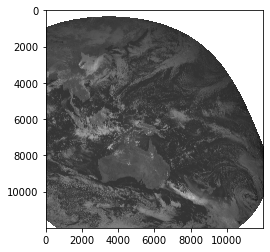

In [215]:
print('Read AHI time: {:.1f} secs'.format(E_Read_AHI_time - S_Read_AHI_time))
print('Process Angle time: {:.1f} secs'.format(E_ANGLE_time - S_ANGLE_time))
print('Process Atmospheric data time: {:.1f} secs'.format(E_ATMOS_time - S_ATMOS_time))
print('Calculate SR time: {:.1f} secs'.format(E_SR_time - S_SR_time))
print('Save SR data time: {:.1f} secs'.format(E_SAVE_time - S_SAVE_time))
print('Total time: {:.1f} secs'.format(TIME))
plt.imshow(SR,cmap='gray')

Read AHI time: 3.8 secs
Process Angle time: 1.3 secs
Process Atmospheric data time: 22.5 secs
Calculate SR time: 31.7 secs
Save SR data time: 1.2 secs
Total time: 60.3 secs


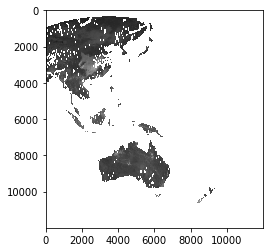

In [221]:
print('Read AHI time: {:.1f} secs'.format(E_Read_AHI_time - S_Read_AHI_time))
print('Process Angle time: {:.1f} secs'.format(E_ANGLE_time - S_ANGLE_time))
print('Process Atmospheric data time: {:.1f} secs'.format(E_ATMOS_time - S_ATMOS_time))
print('Calculate SR time: {:.1f} secs'.format(E_SR_time - S_SR_time))
print('Save SR data time: {:.1f} secs'.format(E_SAVE_time - S_SAVE_time))
print('Total time: {:.1f} secs'.format(TIME))
plt.imshow(SR,cmap='gray')